Математическое моделирование РА с использованием системы уравнений в частных производных с подвижной границей

Импорт библиотек и настройка окружения


In [ ]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import seaborn as sns

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Настройка для поддержки кириллицы
plt.rcParams['font.family'] = 'DejaVu Sans'

# Другие утилиты
import warnings
warnings.filterwarnings('ignore')

# Для сохранения результатов
import os
from datetime import datetime

print(f"Версия NumPy: {np.__version__}")
print(f"Версия Matplotlib: {plt.matplotlib.__version__}")


✅ Все библиотеки успешно импортированы!
🐍 Версия NumPy: 2.3.4
📊 Версия Matplotlib: 3.10.7


Определение параметров модели

In [ ]:
# ГЕОМЕТРИЧЕСКИЕ ПАРАМЕТРЫ
L1 = 0.1          # см - граница синовиальной жидкости/мембраны
h0 = 0.3          # см - начальная толщина синовиальной мембраны
cartilage_thickness = 0.225  # см - начальная толщина хряща
L2 = h0 + cartilage_thickness  # см - внешняя граница хряща (0.525 см)

# ВРЕМЕННЫЕ ПАРАМЕТРЫ 
T_max = 100.0     # дни - период моделирования 
dt = 0.001         # дни - временной шаг
dx = 0.02         # см - пространственный шаг 

# Расчет количества узлов сетки
Nt = int(T_max / dt) + 1  # количество временных шагов 
Nx = int(L2 / dx) + 1     # количество пространственных узлов 

# Создание сеток
t_grid = np.linspace(0, T_max, Nt)
x_grid = np.linspace(0, L2, Nx)

# ГРАНИЧНЫЕ УСЛОВИЯ
alpha = 0.5  # параметр граничного условия на x = L2

print(f"Область синовиальной жидкости:     0.000 < x < {L1:.3f} см")
print(f"Область синовиальной мембраны:     {L1:.3f} < x < {h0:.3f} см (начально)")
print(f"Область хрящевой ткани:           {h0:.3f} < x < {L2:.3f} см")
print(f"\nВременной интервал:                    0 - {T_max:.0f} дней")
print(f"Временной шаг:                    {dt:.5f} дня")
print(f"Пространственный шаг:             {dx:.3f} см")
print(f"\nКоличество временных шагов:            {Nt:,}")
print(f"Количество пространственных узлов:     {Nx}")

📐 ГЕОМЕТРИЧЕСКИЕ И ВРЕМЕННЫЕ ПАРАМЕТРЫ МОДЕЛИ
Область синовиальной жидкости (Ω⁻):     0.000 < x < 0.100 см
Область синовиальной мембраны (Ω₀):     0.100 < x < 0.300 см (начально)
Область хрящевой ткани (Ω₊):           0.300 < x < 0.525 см

Временной интервал:                    0 - 100 дней
Временной шаг (Δt):                    0.01000 дня
Пространственный шаг (Δx):             0.020 см

Количество временных шагов:            10,001
Количество пространственных узлов:     27

⚠️  УПРОЩЁННАЯ МОДЕЛЬ: Хемотаксис ОТКЛЮЧЕН (chi=0)
   Это позволит получить устойчивое решение за разумное время
   Ожидаемое время выполнения: ~1-2 часа


Коэффициенты диффузии

In [ ]:
# Для клеток (см²/день)
delta_M = 8.64e-7      # макрофаги
delta_T17 = 8.64e-7    # Th-17 клетки
delta_F = 8.64e-7      # фибробласты

# Для цитокинов и факторов роста (см²/день)
delta_I17 = 7.44e-2    # интерлейкин-17
delta_I23 = 9.09e-2    # интерлейкин-23
delta_Ta = 8.46e-2     # TNF-α (фактор некроза опухоли альфа)
delta_I6 = 8.63e-2     # интерлейкин-6
delta_S = 9.82e-2      # GM-CSF (гранулоцитарно-макрофагальный колониестимулирующий фактор)
delta_G = 9.58e-2      # FGF (фактор роста фибробластов)
delta_P = 11.2e-2      # MCP-1 (моноцитарный хемоаттрактантный белок-1)
delta_Q = 6.59e-2      # MMP (матриксные металлопротеиназы)
delta_Qr = 8.64e-2     # TIMP (тканевые ингибиторы металлопротеиназ)

# Для лекарственных препаратов (см²/день)
delta_A = 4.78e-2      # инфликсимаб 
delta_Y = 32e-2        # метотрексат 
delta_Z = 4.74e-2      # тоцилизумаб 

print("Коэффициенты диффузии определены")
print(f"   Клетки: {delta_M:.2e} - {delta_F:.2e} см²/день")
print(f"   Цитокины: {delta_I17:.2e} - {delta_P:.2e} см²/день")
print(f"   Лекарства: {delta_A:.2e} - {delta_Y:.2e} см²/день")


✅ Коэффициенты диффузии определены
   Клетки: 8.64e-07 - 8.64e-07 см²/день
   Цитокины: 7.44e-02 - 1.12e-01 см²/день
   Лекарства: 4.78e-02 - 3.20e-01 см²/день


Скорости деградации и гибели клеток


In [ ]:
# ==================== СКОРОСТИ ГИБЕЛИ КЛЕТОК (1/день) ====================
d_M = 0.033       # макрофаги
d_T17 = 0.046     # Th-17 клетки
d_F = 0.3         # фибробласты
d_C = 0.03        # хондроциты

# ==================== СКОРОСТИ ДЕГРАДАЦИИ ВЕЩЕСТВ (1/день) ====================
d_I17 = 0.076     # интерлейкин-17
d_I23 = 2.79      # интерлейкин-23
d_Ta = 217.0      # TNF-α
d_I6 = 0.17       # интерлейкин-6
d_S = 2.38        # GM-CSF
d_G = 1.67        # FGF
d_P = 1.38        # MCP-1
d_Q = 0.138       # MMP
d_Qr = 4.62       # TIMP
d_rho = 0.37      # ECM (внеклеточный матрикс)

# Скорости деградации лекарств (1/день)
d_A = 0.069       # инфликсимаб
d_Y = 2.77        # метотрексат
d_Z = 0.069       # тоцилизумаб

# Специфические скорости деградации (нелинейные члены)
d_MY = 3.3e-1     # деградация макрофагов метотрексатом
d_TaA = 166.15e11 # связывание TNF-α с инфликсимабом (см³/(г·день))
d_CTa = 3e-2      # деградация хондроцитов TNF-α
d_GF = 5.43e-11   # деградация FGF фибробластами
d_PM = 15.55e-10  # деградация MCP-1 макрофагами
d_QQr = 0.138e5   # взаимодействие MMP и TIMP (см³/(г·день))
d_QrQ = 4.6e3     # взаимодействие TIMP и MMP (см³/(г·день))
d_rhoQ = 4.44e3   # деградация ECM матриксными металлопротеиназами (см³/(г·день))

print("Скорости деградации и гибели определены")

✅ Скорости деградации и гибели определены
   Клетки: d_M=0.033, d_T17=0.046, d_F=0.3, d_C=0.03
   Быстрая деградация: d_Ta=217.0 1/день


Начальные концентрации и плотности

In [ ]:
# Клетки
M0 = 1.7e-1       # макрофаги
F0 = 5.5e-2       # фибробласты
T17_0 = 1.8e-3    # Th-17 клетки
C0 = 0.04         # хондроциты (0.023 в некоторых источниках, используем 0.04)
T0 = 2e-4         # наивные T-клетки

# Цитокины и факторы
I17_0 = 5e-12     # интерлейкин-17
I23_0 = 8e-9      # интерлейкин-23
Ta0 = 1.165e-11   # TNF-α
I6_0 = 2e-9       # интерлейкин-6
S0 = 3.5e-12      # GM-CSF
G0 = 0.8e-11      # FGF
P0 = 7e-10        # MCP-1
Q0 = 0.5e-4       # MMP
Qr0 = 0.06e-6     # TIMP

# ECM и лекарства
rho0 = 0.277      # плотность внеклеточного матрикса (из C + ρ = 0.3 г/см³)
A0 = 0.0          # инфликсимаб (начально)
Y0 = 0.0          # метотрексат (начально)
Z0 = 0.0          # тоцилизумаб (начально)

print("Начальные концентрации определены")

✅ Начальные концентрации определены
   Клетки в синовиальной мембране:
      Макрофаги (M): 1.70e-01 г/см³
      Фибробласты (F): 5.50e-02 г/см³
      Th-17 (T17): 1.80e-03 г/см³
   Хондроциты в хряще (C): 4.00e-02 г/см³
   Плотность ECM (ρ): 0.277 г/см³


Константы полунасыщения (параметры Михаэлиса)

In [ ]:
# ==================== КОНСТАНТЫ ПОЛУНАСЫЩЕНИЯ (г/см³) ====================
# все K_X = X⁰ (равновесные концентрации)
K23 = I23_0          # 8e-9 г/см³
K6 = I6_0            # 2e-9 г/см³
K_Z = 1e-11          # константа для тоцилизумаба (из таблицы)
K_T17 = T17_0        # 1.8e-3 г/см³
K_S = S0             # 3.5e-12 г/см³
K_alpha = Ta0        # 1.165e-11 г/см³
K17 = I17_0          # 5e-12 г/см³
K_G = G0             # 0.8e-11 г/см³
K_P = P0             # 7e-10 г/см³
K_I6Y = 1.25e-10     # константа для метотрексата (из таблицы)
K_QY = 1e-10         # константа для метотрексата (из таблицы)

print("Константы полунасыщения определены")

✅ Константы полунасыщения определены
   K23 = 8.00e-09, K6 = 2.00e-09, K_alpha = 1.16e-11 г/см³


Коэффициенты пролиферации и продукции

In [ ]:
# Th-17 клетки (1/день)
lambda_TI23 = 0.0336      # пролиферация Th-17 под действием IL-23
lambda_TI6 = 0.336        # пролиферация Th-17 под действием IL-6
lambda_TTa = 0.336        # пролиферация Th-17 под действием TNF-α

# Макрофаги (1/день)
A_M = 0.33e-6             # базальный приток макрофагов (г/(см³·день))
lambda_MI23 = 0.0484      # пролиферация макрофагов под действием IL-23
lambda_MI6 = 0.0242       # пролиферация макрофагов под действием IL-6
lambda_MS = 0.0242        # пролиферация макрофагов под действием GM-CSF
chi = 5.0e4                 # коэффициент хемотаксиса
# Фибробласты (1/день)
F_max = 1.2e-1            # максимальная плотность фибробластов (г/см³)
lambda_F = 0.33           # базальная пролиферация фибробластов
lambda_FTa = 0.099        # пролиферация фибробластов под действием TNF-α
lambda_FI17 = 0.148       # пролиферация фибробластов под действием IL-17
lambda_FG = 0.0495        # пролиферация фибробластов под действием FGF

# Хондроциты (г/(см³·день))
A_C = 6e-4                # базальная продукция хондроцитов

# ==================== ПРОДУКЦИЯ ЦИТОКИНОВ И ФАКТОРОВ (1/день) ====================
# Интерлейкин-17
lambda_I17T17 = 5.39e-10  # продукция IL-17 Th-17 клетками

# Интерлейкин-23
lambda_I23M = 1.402e-7    # продукция IL-23 макрофагами

# TNF-α
lambda_TaM = 8.1e-9       # продукция TNF-α макрофагами
lambda_TaF = 2.16e-8      # продукция TNF-α фибробластами

# Интерлейкин-6
lambda_I6M = 2.58e-9      # продукция IL-6 макрофагами
lambda_I6F = 6.876e-9     # продукция IL-6 фибробластами

# GM-CSF
lambda_ST17 = 2.368e-9    # продукция GM-CSF Th-17 клетками
lambda_SF = 7.899e-11     # продукция GM-CSF фибробластами
lambda_STa = 2.4          # усиление продукции GM-CSF под действием TNF-α

# FGF (фактор роста фибробластов)
lambda_GM = 6.828e-11     # продукция FGF макрофагами
lambda_GF = 18.216e-11    # продукция FGF фибробластами

# MCP-1 (хемоаттрактант)
lambda_PM = 5.122e-9      # продукция MCP-1 макрофагами
lambda_PF = 1.365e-8      # продукция MCP-1 фибробластами

# MMP (матриксные металлопротеиназы)
lambda_QM = 5.217e-5      # продукция MMP макрофагами
lambda_QF = 13.912e-5     # продукция MMP фибробластами
lambda_QC = 4.743e-5      # продукция MMP хондроцитами

# TIMP (ингибиторы металлопротеиназ)
lambda_QrM = 3.47e-5      # продукция TIMP макрофагами

# ECM (внеклеточный матрикс)
lambda_rhoC = 5.698       # продукция ECM хондроцитами (1/день)

print("Коэффициенты пролиферации и продукции определены")
print(f"   Хемотаксис: χ={chi} см5/(г·день)")


✅ Коэффициенты пролиферации и продукции определены
   Пролиферация Th-17: λ_TI23=0.0336, λ_TI6=0.336
   Базальный приток макрофагов: A_M=3.30e-07 г/(см³·день)
   Хемотаксис: χ=0.0 см³/(г·день)


Параметры лекарственных препаратов

In [ ]:
# Эффективные дозы (г/(см³·день))
gamma_A = 3.45e-12        # инфликсимаб 
gamma_Y = 13.85e-10       # метотрексат 
gamma_Z = 3.45e-12        # тоцилизумаб 

# Скорости взаимодействия лекарств с мишенями (см³/(г·день))
mu_TaA = 2.76e10          # связывание TNF-α с инфликсимабом
mu_MY = 69.25             # взаимодействие макрофагов с метотрексатом
mu_I6 = 1.725             # связывание IL-6 с тоцилизумабом

# Режим введения препаратов
# I_X(t) = 1 для постоянного введения, 0 для отсутствия лечения
def drug_input(t, drug_type='none'):
    """
    Функция режима введения лекарственных препаратов
    
    Параметры:
    -----------
    t : float
        Время (дни)
    drug_type : str
        Тип терапии: 'none', 'infliximab', 'methotrexate', 'tocilizumab', 'combo'
    
    Возвращает:
    -----------
    I_A, I_Y, I_Z : float
        Режимы введения для каждого препарата (0 или 1)
    """
    if drug_type == 'none':
        return 0.0, 0.0, 0.0
    elif drug_type == 'infliximab':
        return 1.0, 0.0, 0.0
    elif drug_type == 'methotrexate':
        return 0.0, 1.0, 0.0
    elif drug_type == 'tocilizumab':
        return 0.0, 0.0, 1.0
    elif drug_type == 'combo_AY':
        return 1.0, 1.0, 0.0  # инфликсимаб + метотрексат
    elif drug_type == 'combo_AZ':
        return 1.0, 0.0, 1.0  # инфликсимаб + тоцилизумаб
    elif drug_type == 'combo_YZ':
        return 0.0, 1.0, 1.0  # метотрексат + тоцилизумаб
    elif drug_type == 'combo_all':
        return 1.0, 1.0, 1.0  # тройная терапия
    else:
        return 0.0, 0.0, 0.0

print("Параметры лекарственных препаратов определены")
print(f"   Инфликсимаб: γ_A={gamma_A:.2e}, μ_TaA={mu_TaA:.2e}")
print(f"   Метотрексат: γ_Y={gamma_Y:.2e}, μ_MY={mu_MY:.2e}")
print(f"   Тоцилизумаб: γ_Z={gamma_Z:.2e}, μ_I6={mu_I6:.2e}")


✅ Параметры лекарственных препаратов определены
   Инфликсимаб: γ_A=3.45e-12, μ_TaA=2.76e+10
   Метотрексат: γ_Y=1.39e-09, μ_MY=6.92e+01
   Тоцилизумаб: γ_Z=3.45e-12, μ_I6=1.73e+00


Начальные и граничные условия

Инициализация пространственных распределений

Согласно физическому смыслу модели, различные переменные локализованы в своих областях:
синовиальная жидкость: клетки отсутствуют, цитокины диффундируют
синовиальная мембрана: все клетки и цитокины присутствуют
хрящевая ткань: только хондроциты и некоторые цитокины


In [ ]:
def initialize_variables():
    """
    Инициализация всех переменных модели с пространственным распределением
    
    Возвращает словарь с начальными распределениями для всех переменных
    """
    # Определяем индексы границ областей
    idx_L1 = int(L1 / dx)  # граница синовиальной жидкости
    idx_h0 = int(h0 / dx)  # начальная граница синовиальной мембраны
    
    # Создаем словарь для хранения всех переменных
    vars_dict = {}
    
    # Клетки
    # Макрофаги (только в синовиальной мембране)
    M = np.zeros(Nx)
    M[idx_L1:idx_h0] = M0
    vars_dict['M'] = M
    
    # Th-17 клетки (только в синовиальной мембране)
    T17 = np.zeros(Nx)
    T17[idx_L1:idx_h0] = T17_0
    vars_dict['T17'] = T17
    
    # Фибробласты (только в синовиальной мембране)
    F = np.zeros(Nx)
    F[idx_L1:idx_h0] = F0
    vars_dict['F'] = F
    
    # Хондроциты (только в хрящевой ткани)
    C = np.zeros(Nx)
    C[idx_h0:] = C0
    vars_dict['C'] = C
    
    # Эти вещества диффундируют во всех областях
    vars_dict['I17'] = np.full(Nx, I17_0)
    vars_dict['I23'] = np.full(Nx, I23_0)
    vars_dict['Ta'] = np.full(Nx, Ta0)
    vars_dict['I6'] = np.full(Nx, I6_0)
    vars_dict['S'] = np.full(Nx, S0)
    vars_dict['G'] = np.full(Nx, G0)
    vars_dict['P'] = np.full(Nx, P0)
    vars_dict['Q'] = np.full(Nx, Q0)
    vars_dict['Qr'] = np.full(Nx, Qr0)
    
    # Внеклеточный матрикс
    # ECM (только в хрящевой ткани)
    rho = np.zeros(Nx)
    rho[idx_h0:] = rho0
    vars_dict['rho'] = rho
    
    # Лекарства
    # Начально отсутствуют
    vars_dict['A'] = np.zeros(Nx)
    vars_dict['Y'] = np.zeros(Nx)
    vars_dict['Z'] = np.zeros(Nx)
    
    # Подвижная граница
    vars_dict['h'] = h0
    
    return vars_dict

# Инициализация начальных условий
initial_vars = initialize_variables()


print("НАЧАЛЬНЫЕ УСЛОВИЯ ИНИЦИАЛИЗИРОВАНЫ")
for var_name in initial_vars.keys():
    if var_name != 'h':
        min_val = initial_vars[var_name].min()
        max_val = initial_vars[var_name].max()
        print(f"   {var_name:5s}: min={min_val:.2e}, max={max_val:.2e} г/см³")
    else:
        print(f"   {var_name:5s}: {initial_vars[var_name]:.4f} см")

✅ НАЧАЛЬНЫЕ УСЛОВИЯ ИНИЦИАЛИЗИРОВАНЫ
Переменные модели:
   M    : min=0.00e+00, max=1.70e-01 г/см³
   T17  : min=0.00e+00, max=1.80e-03 г/см³
   F    : min=0.00e+00, max=5.50e-02 г/см³
   C    : min=0.00e+00, max=4.00e-02 г/см³
   I17  : min=5.00e-12, max=5.00e-12 г/см³
   I23  : min=8.00e-09, max=8.00e-09 г/см³
   Ta   : min=1.16e-11, max=1.16e-11 г/см³
   I6   : min=2.00e-09, max=2.00e-09 г/см³
   S    : min=3.50e-12, max=3.50e-12 г/см³
   G    : min=8.00e-12, max=8.00e-12 г/см³
   P    : min=7.00e-10, max=7.00e-10 г/см³
   Q    : min=5.00e-05, max=5.00e-05 г/см³
   Qr   : min=6.00e-08, max=6.00e-08 г/см³
   rho  : min=0.00e+00, max=2.77e-01 г/см³
   A    : min=0.00e+00, max=0.00e+00 г/см³
   Y    : min=0.00e+00, max=0.00e+00 г/см³
   Z    : min=0.00e+00, max=0.00e+00 г/см³
   h    : 0.3000 см


Численные методы решения

 Метод Кранка-Николсона для уравнений реакция-диффузия

Метод Кранка-Николсона - это неявная схема второго порядка точности для решения параболических уравнений вида:

$$\frac{\partial u}{\partial t} = \delta \frac{\partial^2 u}{\partial x^2} + R(u)$$

Схема:
$$\frac{u^{n+1} - u^n}{\Delta t} = \frac{\delta}{2} \left( \frac{\partial^2 u^{n+1}}{\partial x^2} + \frac{\partial^2 u^n}{\partial x^2} \right) + \frac{1}{2}(R^{n+1} + R^n)$$

Это приводит к системе линейных уравнений на каждом временном шаге.


In [ ]:
def create_diffusion_matrix(delta, boundary_type='neumann'):
    """
    Создание трехдиагональной матрицы для диффузии (метод Кранка-Николсона)
    
    Параметры:
    -----------
    delta : float
        Коэффициент диффузии
    boundary_type : str
        Тип граничных условий: 'neumann' или 'robin'
    
    Возвращает:
    -----------
    A_left, A_right : sparse matrix
        Матрицы для левой и правой частей уравнения
    """
    # Параметр устойчивости
    r = delta * dt / (2 * dx**2)
    
    # Главная диагональ
    main_diag = (1 + 2*r) * np.ones(Nx)
    # Побочные диагонали
    off_diag = -r * np.ones(Nx-1)
    
    # Создаем трехдиагональную матрицу для левой части (неявная)
    A_left = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csr')
    
    # Матрица для правой части (явная)
    main_diag_right = (1 - 2*r) * np.ones(Nx)
    off_diag_right = r * np.ones(Nx-1)
    A_right = diags([off_diag_right, main_diag_right, off_diag_right], [-1, 0, 1], format='csr')
    
    return A_left, A_right


def apply_neumann_bc(A_left, A_right, position='both'):
    """
    Применение граничных условий Неймана (∂u/∂x = 0)
    
    Параметры:
    -----------
    A_left, A_right : sparse matrix
        Матрицы диффузии
    position : str
        'left' - только на левой границе
        'right' - только на правой границе
        'both' - на обеих границах
    
    Возвращает:
    -----------
    A_left, A_right : модифицированные матрицы
    """
    A_left = A_left.tolil()
    A_right = A_right.tolil()
    
    if position in ['left', 'both']:
        # Левая граница: ∂u/∂x = 0 => u[0] = u[1]
        A_left[0, :] = 0
        A_left[0, 0] = 1
        A_left[0, 1] = -1
        
        A_right[0, :] = 0
        A_right[0, 0] = 1
        A_right[0, 1] = -1
    
    if position in ['right', 'both']:
        # Правая граница: ∂u/∂x = 0 => u[-1] = u[-2]
        A_left[-1, :] = 0
        A_left[-1, -1] = 1
        A_left[-1, -2] = -1
        
        A_right[-1, :] = 0
        A_right[-1, -1] = 1
        A_right[-1, -2] = -1
    
    return A_left.tocsr(), A_right.tocsr()


def apply_robin_bc(A_left, A_right, alpha_param):
    """
    Применение граничного условия Робина на правой границе:
    ∂u/∂x + α·u = 0 на x = L2
    
    Параметры:
    -----------
    A_left, A_right : sparse matrix
        Матрицы диффузии
    alpha_param : float
        Параметр граничного условия
    
    Возвращает:
    -----------
    A_left, A_right : модифицированные матрицы
    """
    A_left = A_left.tolil()
    A_right = A_right.tolil()
    
    # На правой границе: (u[-1] - u[-2])/dx + alpha * u[-1] = 0
    # Переписываем: u[-1] = u[-2] / (1 + alpha*dx)
    coef = 1.0 / (1.0 + alpha_param * dx)
    
    A_left[-1, :] = 0
    A_left[-1, -1] = 1
    A_left[-1, -2] = -coef
    
    A_right[-1, :] = 0
    A_right[-1, -1] = 1
    A_right[-1, -2] = -coef
    
    return A_left.tocsr(), A_right.tocsr()


print("Функции для численных методов определены")

✅ Функции для численных методов определены
   - Метод Кранка-Николсона для диффузии
   - Граничные условия Неймана и Робина


Реакционные члены уравнений

Каждое уравнение модели имеет диффузионный и реакционный члены. Реакционные члены описывают:
- Пролиферацию клеток
- Продукцию цитокинов
- Деградацию веществ
- Взаимодействия между компонентами

Определим функции для вычисления реакционных членов всех уравнений.


In [ ]:
def reaction_T17(T17, I23, I6, Ta, Z, Y):
    """
    Реакционный член для Th-17 клеток (уравнение 2.1)
    """
    term1 = lambda_TI23 * T17 * I23 / (K23 + I23)
    term2 = lambda_TI6 / (1 + Z/K_Z) * T0 * I6 / (K6 + I6)
    term3 = lambda_TTa * T0 * Ta / (K_alpha + Ta)
    term4 = -d_T17 * T17
    return term1 + term2 + term3 + term4


def reaction_M(M, P, T17, I23, I6, S, Y):
    """
    Реакционный член для макрофагов (уравнение 2.2)
    Включает базальный приток, пролиферацию и деградацию
    """
    # Базальный приток
    term1 = A_M
    
    # Пролиферация под действием цитокинов
    term2 = lambda_MI23 * M * (T17 / (K_T17 + T17)) * (I23 / (K23 + I23))
    term3 = lambda_MI6 / (1 + Y/K_I6Y) * M * I6 / (K6 + I6)
    term4 = lambda_MS * M * S / (K_S + S)
    
    # Деградация
    term5 = -d_M * M
    term6 = -d_MY * Y * M
    
    return term1 + term2 + term3 + term4 + term5 + term6


def chemotaxis_M(M, P):
    """
    Член хемотаксиса для макрофагов: -∂/∂x(M·χ·∂P/∂x)
    Вычисляется с использованием центральных разностей
    """
    dP_dx = np.gradient(P, dx)
    flux = M * chi * dP_dx
    div_flux = -np.gradient(flux, dx)
    return div_flux


def reaction_F(F, Ta, I17, G):
    """
    Реакционный член для фибробластов (уравнение 2.3)
    """
    term1 = lambda_F * F * (1 - F/F_max)
    term2 = lambda_FTa * F * Ta / (K_alpha + Ta)
    term3 = lambda_FI17 * F * I17 / (K17 + I17)
    term4 = lambda_FG * F * G / (K_G + G)
    term5 = -d_F * F
    return term1 + term2 + term3 + term4 + term5


def reaction_I17(T17):
    """
    Реакционный член для интерлейкина-17 (уравнение 2.4)
    """
    return lambda_I17T17 * T17 - d_I17


def reaction_I23(M):
    """
    Реакционный член для интерлейкина-23 (уравнение 2.5)
    """
    return lambda_I23M * M - d_I23


def reaction_Ta(M, F, A):
    """
    Реакционный член для TNF-α (уравнение 2.6)
    Включает продукцию макрофагами и фибробластами, связывание с инфликсимабом
    """
    production = lambda_TaM * M + lambda_TaF * F
    degradation = d_Ta + d_TaA * A
    return production - degradation


def reaction_I6(M, F, Y):
    """
    Реакционный член для интерлейкина-6 (уравнение 2.7)
    """
    term1 = lambda_I6M * M / (1 + Y/K_I6Y)
    term2 = lambda_I6F * F
    term3 = -d_I6
    return term1 + term2 + term3


def reaction_S(T17, F, Ta):
    """
    Реакционный член для GM-CSF (уравнение 2.8)
    """
    term1 = lambda_ST17 * T17
    term2 = lambda_SF * F * (1 + lambda_STa * Ta / (K_alpha + Ta))
    term3 = -d_S
    return term1 + term2 + term3


def reaction_G(M, F):
    """
    Реакционный член для FGF (уравнение 2.9)
    """
    production = lambda_GM * M + lambda_GF * F
    degradation = d_GF * F / (K_G + 1e-20)  # малое число для избежания деления на 0
    return production - degradation - d_G


def reaction_P(M, F):
    """
    Реакционный член для MCP-1 (уравнение 2.10)
    """
    production = lambda_PM * M + lambda_PF * F
    degradation = d_PM * M / (K_P + 1e-20)
    return production - degradation - d_P


def reaction_Q(M, F, C, Qr, Y, is_cartilage=False):
    """
    Реакционный член для MMP (уравнения 2.11, 2.24)
    
    Параметры:
    -----------
    is_cartilage : bool
        Если True, используется уравнение для хрящевой ткани (с хондроцитами)
    """
    if is_cartilage:
        # В хрящевой ткани: продукция только хондроцитами
        production = lambda_QC * C
    else:
        # В синовиальной мембране: продукция макрофагами и фибробластами
        production = lambda_QM / (1 + Y/K_QY) * M + lambda_QF * F
    
    degradation = d_QQr * Qr + d_Q
    return production - degradation


def reaction_Qr(M, Y):
    """
    Реакционный член для TIMP (уравнение 2.12)
    """
    # gamma_Y используется как множитель для влияния метотрексата
    production = lambda_QrM * M * (1 + gamma_Y * Y / (gamma_Y + 1e-20))
    return production - d_Qr


def reaction_A(I_A, Ta):
    """
    Реакционный член для инфликсимаба (уравнение 2.13)
    
    Параметры:
    -----------
    I_A : float
        Режим введения (0 или 1)
    """
    input_term = gamma_A * I_A
    binding = mu_TaA * Ta
    return input_term - binding - d_A


def reaction_Y(I_Y, M):
    """
    Реакционный член для метотрексата (уравнение 2.14)
    """
    input_term = gamma_Y * I_Y
    interaction = mu_MY * M
    return input_term - interaction - d_Y


def reaction_Z(I_Z, T0_val, M):
    """
    Реакционный член для тоцилизумаба (уравнение 2.15)
    """
    input_term = gamma_Z * I_Z
    binding = mu_I6 * (T0_val + M)
    return input_term - binding - d_Z


print("Функции реакционных членов определены")
print(f"   Всего {13} основных реакционных функций для уравнений модели")


✅ Функции реакционных членов определены
   Всего 13 основных реакционных функций для уравнений модели


Уравнения для хрящевой ткани с подвижной границей

В хрящевой ткани рассматриваются:
- Хондроциты (C)
- Плотность внеклеточного матрикса (ρ)
- Скорость движения границы V(x,t)
- Движение границы синовиальной мембраны h(t)


In [ ]:
def reaction_C(C, Ta):
    """
    Реакционный член для хондроцитов (уравнение 2.16)
    Включает базальный приток, деградацию TNF-α и естественную гибель
    """
    term1 = A_C
    term2 = -d_CTa * C * Ta / (K_alpha + Ta)
    term3 = -d_C * C
    return term1 + term2 + term3


def reaction_Ta_cartilage(C, Ta):
    """
    Реакционный член для TNF-α в хряще (уравнение 2.23)
    В хрящевой ткани нет продукции, только деградация
    """
    term1 = -d_CTa * C * Ta / (K_alpha + Ta)  # деградация хондроцитами (используем d_Ta)
    term2 = -d_Ta * Ta  # естественная деградация
    return term1 + term2


def reaction_rho(C, Q):
    """
    Реакционный член для ECM (внеклеточного матрикса, уравнение 2.17)
    """
    production = lambda_rhoC * C
    degradation = d_rhoQ * Q + d_rho
    return production - degradation


def compute_H_field(C, Ta, Q, rho):
    """
    Вычисление поля H для уравнения скорости (уравнение 2.20)
    H = A_C - d_CTa·C·Ta/(K_alpha+Ta) - d_C·C + lambda_rhoC·C - d_rhoQ·rho·Q - d_rho·rho
    """
    H = A_C - d_CTa * C * Ta / (K_alpha + Ta) - d_C * C
    H += lambda_rhoC * C - d_rhoQ * rho * Q - d_rho * rho
    return H


def compute_velocity(H, x_grid, idx_h, idx_L2):
    """
    Вычисление скорости V(x,t) из уравнения (2.21)
    V(x,t) = -1/0.3 * ∫[x to L2] H(x',t) dx'
    
    Параметры:
    -----------
    H : array
        Поле H(x,t)
    x_grid : array
        Пространственная сетка
    idx_h : int
        Индекс границы h(t)
    idx_L2 : int
        Индекс границы L2
    
    Возвращает:
    -----------
    V : array
        Поле скорости
    """
    V = np.zeros_like(H)
    
    # Интегрируем от x до L2 для каждой точки в хрящевой ткани
    for i in range(idx_h, idx_L2 + 1):
        # Интеграл от x[i] до L2
        integral = np.trapz(H[i:idx_L2+1], x_grid[i:idx_L2+1])
        V[i] = -integral / 0.3  # Плотность C + rho = 0.3 г/см³
    
    return V


def update_h(h_current, V_at_h):
    """
    Обновление положения границы h(t) (уравнение 2.22)
    dh/dt = V(h(t), t)
    
    Параметры:
    -----------
    h_current : float
        Текущее положение границы
    V_at_h : float
        Скорость на границе
    
    Возвращает:
    -----------
    h_new : float
        Новое положение границы
    """
    h_new = h_current + dt * V_at_h
    return h_new


def advection_term(u, V):
    """
    Член переноса: ∂(V·u)/∂x
    Используется upwind-схема для устойчивости
    """
    du_dx = np.zeros_like(u)
    
    for i in range(1, len(u)-1):
        if V[i] >= 0:
            # Upwind схема: используем левую разность
            du_dx[i] = V[i] * (u[i] - u[i-1]) / dx
        else:
            # Downwind схема: используем правую разность
            du_dx[i] = V[i] * (u[i+1] - u[i]) / dx
    
    return du_dx


print("Функции для хрящевой ткани и подвижной границы определены")

✅ Функции для хрящевой ткани и подвижной границы определены
   - Уравнения для хондроцитов и ECM
   - Вычисление скорости V(x,t)
   - Обновление границы h(t)


Функция временного интегрирования

Главная функция, которая интегрирует всю систему уравнений по времени с учетом:
- Метода Кранка-Николсона для диффузии
- Полунеявного учета реакционных членов
- Подвижной границы h(t)
- Граничных условий для всех областей


Безопасные функции с ограничениями

Добавим критические проверки для предотвращения нефизичных значений.


In [ ]:
def update_h_safe(h_current, V_at_h, dt):
    """
    Безопасное обновление границы h с критическими ограничениями
    
    Параметры:
    -----------
    h_current : float
        Текущее положение границы
    V_at_h : float
        Скорость на границе
    dt : float
        Временной шаг
    
    Возвращает:
    -----------
    h_new : float
        Новое положение границы (ограниченное)
    """
    # Ограничиваем скорость изменения
    max_velocity = 0.0001  # см/день - максимально разумная скорость
    V_at_h_limited = np.clip(V_at_h, -max_velocity, max_velocity)
    
    # Обновляем
    h_new = h_current + dt * V_at_h_limited
    
    # КРИТИЧЕСКОЕ ОГРАНИЧЕНИЕ: h должна быть между L1 и L2
    h_new = np.clip(h_new, L1 + 0.01, L2 - 0.01)
    
    return h_new


def safe_gradient_2nd(u, dx):
    """
    Безопасное вычисление второй производной с центральными разностями
    ∂²u/∂x² ≈ (u[i-1] - 2*u[i] + u[i+1]) / dx²
    
    Параметры:
    -----------
    u : array
        Функция
    dx : float
        Шаг сетки
    
    Возвращает:
    -----------
    d2u : array
        Вторая производная
    """
    d2u = np.zeros_like(u)
    
    # Внутренние точки
    for i in range(1, len(u)-1):
        d2u[i] = (u[i-1] - 2*u[i] + u[i+1]) / (dx**2)
    
    # Граничные условия Неймана: du/dx = 0
    d2u[0] = d2u[1]
    d2u[-1] = d2u[-2]
    
    return d2u


print("Безопасные функции обновления определены")
print(" update_h_safe: ограничение скорости и диапазона h")
print("   -safe_gradient_2nd: правильная вторая производная")


✅ Безопасные функции обновления определены
   - update_h_safe: ограничение скорости и диапазона h
   - safe_gradient_2nd: правильная вторая производная


In [14]:
def solve_RA_model(drug_type='none', save_interval=100, verbose=True):
    """
    Главная функция решения модели ревматоидного артрита
    
    Параметры:
    -----------
    drug_type : str
        Тип терапии ('none', 'infliximab', 'methotrexate', 'tocilizumab', 'combo_...')
    save_interval : int
        Интервал сохранения данных (в шагах по времени)
    verbose : bool
        Печатать прогресс выполнения
    
    Возвращает:
    -----------
    results : dict
        Словарь с результатами симуляции
    """
    if verbose:
        print("=" * 70)
        print(f"🚀 ЗАПУСК СИМУЛЯЦИИ: {drug_type}")
        print("=" * 70)
    
    # Инициализация переменных
    vars_current = initialize_variables()
    
    # История для сохранения результатов
    n_saves = Nt // save_interval + 1
    history = {
        'time': [],
        'h': np.zeros(n_saves),
        'M': np.zeros((n_saves, Nx)),
        'T17': np.zeros((n_saves, Nx)),
        'F': np.zeros((n_saves, Nx)),
        'C': np.zeros((n_saves, Nx)),
        'I17': np.zeros((n_saves, Nx)),
        'I23': np.zeros((n_saves, Nx)),
        'Ta': np.zeros((n_saves, Nx)),
        'I6': np.zeros((n_saves, Nx)),
        'S': np.zeros((n_saves, Nx)),
        'G': np.zeros((n_saves, Nx)),
        'P': np.zeros((n_saves, Nx)),
        'Q': np.zeros((n_saves, Nx)),
        'Qr': np.zeros((n_saves, Nx)),
        'rho': np.zeros((n_saves, Nx)),
        'A': np.zeros((n_saves, Nx)),
        'Y': np.zeros((n_saves, Nx)),
        'Z': np.zeros((n_saves, Nx))
    }
    
    save_idx = 0
    
    # Временной цикл
    for n in range(Nt):
        t = n * dt
        
        # Получаем режим введения препаратов
        I_A, I_Y, I_Z = drug_input(t, drug_type)
        
        # Определяем индексы границ областей
        idx_L1 = int(L1 / dx)
        idx_h = int(vars_current['h'] / dx)
        idx_L2 = Nx - 1
        
        # ============ ОБНОВЛЕНИЕ ПЕРЕМЕННЫХ В СИНОВИАЛЬНОЙ МЕМБРАНЕ ============
        # (детальная реализация в следующей ячейке)
        vars_current = update_synovial_variables(vars_current, I_A, I_Y, I_Z, idx_L1, idx_h)
        
        # ============ ОБНОВЛЕНИЕ ПЕРЕМЕННЫХ В ХРЯЩЕВОЙ ТКАНИ ============
        vars_current = update_cartilage_variables(vars_current, idx_h, idx_L2)
        
        # ============ ОБНОВЛЕНИЕ ГРАНИЦЫ H(T) ============
        H_field = compute_H_field(vars_current['C'], vars_current['Ta'], 
                                   vars_current['Q'], vars_current['rho'])
        V_field = compute_velocity(H_field, x_grid, idx_h, idx_L2)
        
        # Скорость на границе
        V_at_h = V_field[idx_h] if idx_h < len(V_field) else 0.0
        vars_current['h'] = update_h(vars_current['h'], V_at_h)
        
        # Сохранение результатов
        if n % save_interval == 0:
            history['time'].append(t)
            history['h'][save_idx] = vars_current['h']
            for var_name in ['M', 'T17', 'F', 'C', 'I17', 'I23', 'Ta', 'I6', 
                            'S', 'G', 'P', 'Q', 'Qr', 'rho', 'A', 'Y', 'Z']:
                history[var_name][save_idx, :] = vars_current[var_name]
            save_idx += 1
        
        # Печать прогресса
        if verbose and n % (Nt // 10) == 0:
            print(f"   Прогресс: {100*n/Nt:.1f}% | День {t:.1f} | h = {vars_current['h']:.4f} см")
    
    if verbose:
        print(f"   Прогресс: 100.0% | День {T_max:.1f} | h = {vars_current['h']:.4f} см")
        print("✅ СИМУЛЯЦИЯ ЗАВЕРШЕНА")
        print("=" * 70)
    
    # Обрезаем историю до фактического размера
    history['h'] = history['h'][:save_idx]
    for var_name in ['M', 'T17', 'F', 'C', 'I17', 'I23', 'Ta', 'I6', 
                    'S', 'G', 'P', 'Q', 'Qr', 'rho', 'A', 'Y', 'Z']:
        history[var_name] = history[var_name][:save_idx, :]
    
    return history


print("✅ Структура главного солвера определена")


✅ Структура главного солвера определена


### 5.2 Функции обновления переменных

Вспомогательные функции для обновления всех переменных модели с использованием упрощенной схемы.


In [15]:
def update_synovial_variables(vars_dict, I_A, I_Y, I_Z, idx_L1, idx_h):
    """
    Обновление переменных в синовиальной мембране (область Ω₀)
    Используется упрощенная явная схема для быстрых расчетов
    
    Параметры:
    -----------
    vars_dict : dict
        Словарь с текущими значениями переменных
    I_A, I_Y, I_Z : float
        Режимы введения препаратов
    idx_L1 : int
        Индекс границы L1
    idx_h : int
        Индекс текущей границы h(t)
    
    Возвращает:
    -----------
    vars_dict : dict
        Обновленный словарь переменных
    """
    # Извлекаем текущие значения
    M = vars_dict['M'].copy()
    T17 = vars_dict['T17'].copy()
    F = vars_dict['F'].copy()
    I17 = vars_dict['I17'].copy()
    I23 = vars_dict['I23'].copy()
    Ta = vars_dict['Ta'].copy()
    I6 = vars_dict['I6'].copy()
    S = vars_dict['S'].copy()
    G = vars_dict['G'].copy()
    P = vars_dict['P'].copy()
    Q = vars_dict['Q'].copy()
    Qr = vars_dict['Qr'].copy()
    A = vars_dict['A'].copy()
    Y = vars_dict['Y'].copy()
    Z = vars_dict['Z'].copy()
    C = vars_dict['C'].copy()
    
    # Обновление Th-17 клеток (с диффузией)
    R_T17 = reaction_T17(T17, I23, I6, Ta, Z, Y)
    T17_new = T17 + dt * (delta_T17 * np.gradient(np.gradient(T17, dx), dx) + R_T17)
    T17_new = np.maximum(T17_new, 0)  # Неотрицательность
    vars_dict['T17'] = T17_new
    
    # Обновление макрофагов (с диффузией и хемотаксисом)
    R_M = reaction_M(M, P, T17, I23, I6, S, Y)
    chem = chemotaxis_M(M, P)
    M_new = M + dt * (delta_M * np.gradient(np.gradient(M, dx), dx) + chem + R_M)
    M_new = np.maximum(M_new, 0)
    vars_dict['M'] = M_new
    
    # Обновление фибробластов (с диффузией)
    R_F = reaction_F(F, Ta, I17, G)
    F_new = F + dt * (delta_F * np.gradient(np.gradient(F, dx), dx) + R_F)
    F_new = np.maximum(F_new, 0)
    vars_dict['F'] = F_new
    
    # Обновление цитокинов и факторов
    # IL-17
    R_I17 = reaction_I17(T17)
    I17_new = I17 + dt * (delta_I17 * np.gradient(np.gradient(I17, dx), dx) + R_I17 * I17)
    vars_dict['I17'] = np.maximum(I17_new, 0)
    
    # IL-23
    R_I23 = reaction_I23(M)
    I23_new = I23 + dt * (delta_I23 * np.gradient(np.gradient(I23, dx), dx) + R_I23 * I23)
    vars_dict['I23'] = np.maximum(I23_new, 0)
    
    # TNF-α
    R_Ta = reaction_Ta(M, F, A)
    Ta_new = Ta + dt * (delta_Ta * np.gradient(np.gradient(Ta, dx), dx) + R_Ta * Ta)
    vars_dict['Ta'] = np.maximum(Ta_new, 0)
    
    # IL-6
    R_I6 = reaction_I6(M, F, Y)
    I6_new = I6 + dt * (delta_I6 * np.gradient(np.gradient(I6, dx), dx) + R_I6 * I6)
    vars_dict['I6'] = np.maximum(I6_new, 0)
    
    # GM-CSF
    R_S = reaction_S(T17, F, Ta)
    S_new = S + dt * (delta_S * np.gradient(np.gradient(S, dx), dx) + R_S * S)
    vars_dict['S'] = np.maximum(S_new, 0)
    
    # FGF
    R_G = reaction_G(M, F)
    G_new = G + dt * (delta_G * np.gradient(np.gradient(G, dx), dx) + R_G * G)
    vars_dict['G'] = np.maximum(G_new, 0)
    
    # MCP-1
    R_P = reaction_P(M, F)
    P_new = P + dt * (delta_P * np.gradient(np.gradient(P, dx), dx) + R_P * P)
    vars_dict['P'] = np.maximum(P_new, 0)
    
    # MMP
    R_Q = reaction_Q(M, F, C, Qr, Y, is_cartilage=False)
    Q_new = Q + dt * (delta_Q * np.gradient(np.gradient(Q, dx), dx) + R_Q * Q)
    vars_dict['Q'] = np.maximum(Q_new, 0)
    
    # TIMP
    R_Qr = reaction_Qr(M, Y)
    Qr_new = Qr + dt * (delta_Qr * np.gradient(np.gradient(Qr, dx), dx) + R_Qr * Qr)
    vars_dict['Qr'] = np.maximum(Qr_new, 0)
    
    # Лекарственные препараты
    R_A = reaction_A(I_A, Ta)
    A_new = A + dt * (delta_A * np.gradient(np.gradient(A, dx), dx) + R_A * A)
    vars_dict['A'] = np.maximum(A_new, 0)
    
    R_Y = reaction_Y(I_Y, M)
    Y_new = Y + dt * (delta_Y * np.gradient(np.gradient(Y, dx), dx) + R_Y * Y)
    vars_dict['Y'] = np.maximum(Y_new, 0)
    
    R_Z = reaction_Z(I_Z, T0, M)
    Z_new = Z + dt * (delta_Z * np.gradient(np.gradient(Z, dx), dx) + R_Z * Z)
    vars_dict['Z'] = np.maximum(Z_new, 0)
    
    return vars_dict


def update_cartilage_variables(vars_dict, idx_h, idx_L2):
    """
    Обновление переменных в хрящевой ткани (область Ω₊)
    
    Параметры:
    -----------
    vars_dict : dict
        Словарь с текущими значениями переменных
    idx_h : int
        Индекс границы h(t)
    idx_L2 : int
        Индекс правой границы L2
    
    Возвращает:
    -----------
    vars_dict : dict
        Обновленный словарь переменных
    """
    C = vars_dict['C'].copy()
    Ta = vars_dict['Ta'].copy()
    Q = vars_dict['Q'].copy()
    rho = vars_dict['rho'].copy()
    
    # Вычисляем поле H и скорость
    H = compute_H_field(C, Ta, Q, rho)
    V = compute_velocity(H, x_grid, idx_h, idx_L2)
    
    # Обновление хондроцитов (с переносом)
    R_C = reaction_C(C, Ta)
    adv_C = advection_term(C, V)
    C_new = C + dt * (-adv_C + R_C)
    C_new = np.maximum(C_new, 0)
    vars_dict['C'] = C_new
    
    # Обновление ECM (с переносом)
    R_rho = reaction_rho(C, Q)
    adv_rho = advection_term(rho, V)
    rho_new = rho + dt * (-adv_rho + R_rho)
    rho_new = np.maximum(rho_new, 0)
    vars_dict['rho'] = rho_new
    
    # TNF-α в хряще (только диффузия и деградация)
    R_Ta_cart = reaction_Ta_cartilage(C, Ta)
    Ta_new = Ta + dt * (delta_Ta * np.gradient(np.gradient(Ta, dx), dx) + R_Ta_cart * Ta)
    vars_dict['Ta'] = np.maximum(Ta_new, 0)
    
    # MMP в хряще
    R_Q_cart = reaction_Q(0, 0, C, vars_dict['Qr'], 0, is_cartilage=True)
    Q_new = Q + dt * (delta_Q * np.gradient(np.gradient(Q, dx), dx) + R_Q_cart * Q)
    vars_dict['Q'] = np.maximum(Q_new, 0)
    
    return vars_dict


print("✅ Функции обновления переменных определены")
print("   - update_synovial_variables: обновление в синовиальной мембране")
print("   - update_cartilage_variables: обновление в хрящевой ткани")


✅ Функции обновления переменных определены
   - update_synovial_variables: обновление в синовиальной мембране
   - update_cartilage_variables: обновление в хрящевой ткани


### 5.3 Проверка численной устойчивости

Добавим функцию для проверки стабильности и диагностики проблем.


In [16]:
def check_stability(vars_dict, step_number, verbose=False):
    """
    Проверка численной устойчивости решения
    
    Параметры:
    -----------
    vars_dict : dict
        Словарь с текущими значениями переменных
    step_number : int
        Номер временного шага
    verbose : bool
        Печатать детальную информацию
    
    Возвращает:
    -----------
    is_stable : bool
        True если всё стабильно, False если обнаружены проблемы
    """
    is_stable = True
    problems = []
    
    # Проверяем каждую переменную
    for var_name, var_data in vars_dict.items():
        if var_name == 'h':
            # Проверка границы
            if var_data > L2 or var_data < L1:
                problems.append(f"{var_name}: вне допустимых пределов ({var_data:.4f})")
                is_stable = False
            continue
        
        # Проверка на NaN
        if np.any(np.isnan(var_data)):
            problems.append(f"{var_name}: содержит NaN")
            is_stable = False
        
        # Проверка на Inf
        if np.any(np.isinf(var_data)):
            problems.append(f"{var_name}: содержит Inf")
            is_stable = False
        
        # Проверка на отрицательные значения
        if np.any(var_data < -1e-10):
            problems.append(f"{var_name}: отрицательные значения (min={np.min(var_data):.2e})")
            is_stable = False
        
        # Проверка на разумность значений (не слишком большие)
        max_val = np.max(np.abs(var_data))
        expected_max = {
            'M': 1.0, 'T17': 0.1, 'F': 1.0, 'C': 0.5,
            'I17': 1e-8, 'I23': 1e-6, 'Ta': 1e-8, 'I6': 1e-6,
            'S': 1e-9, 'G': 1e-9, 'P': 1e-7,
            'Q': 1e-2, 'Qr': 1e-4, 'rho': 1.0,
            'A': 1e-9, 'Y': 1e-7, 'Z': 1e-9
        }
        
        if var_name in expected_max and max_val > expected_max[var_name] * 100:
            problems.append(f"{var_name}: слишком большое значение (max={max_val:.2e})")
            is_stable = False
    
    if not is_stable and verbose:
        print(f"\n⚠️  ПРОБЛЕМА УСТОЙЧИВОСТИ на шаге {step_number}!")
        for prob in problems:
            print(f"   - {prob}")
    
    return is_stable


# Проверка параметров численной схемы
print("=" * 70)
print("🔍 ПРОВЕРКА ПАРАМЕТРОВ ЧИСЛЕННОЙ СХЕМЫ")
print("=" * 70)

# Число Куранта для диффузии
CFL_diff_max = max(delta_M, delta_T17, delta_F, delta_I17, delta_I23, delta_Ta, 
                   delta_I6, delta_S, delta_G, delta_P, delta_Q, delta_Qr) * dt / dx**2
print(f"Максимальное число Куранта (диффузия): CFL = {CFL_diff_max:.4f}")
if CFL_diff_max > 0.5:
    print(f"  ⚠️  ВНИМАНИЕ: CFL > 0.5 - может быть неустойчиво для явной схемы!")
    print(f"     Рекомендуется: уменьшить dt или увеличить dx")
else:
    print(f"  ✓ CFL ≤ 0.5 - приемлемо")

# Число для хемотаксиса
CFL_chem = chi * dt / dx
print(f"\nЧисло Куранта (хемотаксис): CFL_chem = {CFL_chem:.4f}")
if CFL_chem > 1.0:
    print(f"  ⚠️  ВНИМАНИЕ: CFL_chem > 1 - может вызвать нестабильность!")
    print(f"     Рекомендуется: уменьшить chi или dt, или увеличить dx")
else:
    print(f"  ✓ CFL_chem ≤ 1 - хорошо!")

# Общее количество шагов
total_steps = Nt
expected_time_hours = total_steps * 0.005 / 3600  # ~0.005 сек на шаг
print(f"\nОбщее количество временных шагов: {total_steps:,}")
print(f"Пространственных узлов: {Nx}")
print(f"Ожидаемое время выполнения: ~{expected_time_hours:.1f}-{expected_time_hours*2:.1f} часов")

print("=" * 70)


🔍 ПРОВЕРКА ПАРАМЕТРОВ ЧИСЛЕННОЙ СХЕМЫ
Максимальное число Куранта (диффузия): CFL = 2.8000
  ⚠️  ВНИМАНИЕ: CFL > 0.5 - может быть неустойчиво для явной схемы!
     Рекомендуется: уменьшить dt или увеличить dx

Число Куранта (хемотаксис): CFL_chem = 0.0000
  ✓ CFL_chem ≤ 1 - хорошо!

Общее количество временных шагов: 10,001
Пространственных узлов: 27
Ожидаемое время выполнения: ~0.0-0.0 часов


In [17]:
def plot_temporal_dynamics(history, save_path=None):
    """
    Построение графиков временной динамики всех переменных
    
    Параметры:
    -----------
    history : dict
        Результаты симуляции
    save_path : str
        Путь для сохранения графика
    """
    time = np.array(history['time'])
    
    # Вычисляем средние значения по пространству для каждого временного момента
    def spatial_average(var_data, idx_start, idx_end):
        """Вычисление среднего по области"""
        return np.mean(var_data[:, idx_start:idx_end], axis=1)
    
    idx_L1 = int(L1 / dx)
    idx_h0 = int(h0 / dx)
    
    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Временная динамика переменных модели ревматоидного артрита', 
                 fontsize=18, fontweight='bold')
    
    # 1. Клетки
    ax = axes[0, 0]
    M_avg = spatial_average(history['M'], idx_L1, idx_h0)
    ax.plot(time, M_avg * 1e3, 'r-', linewidth=2, label='Макрофаги')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (мг/см³)')
    ax.set_title('Макрофаги (M)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[0, 1]
    T17_avg = spatial_average(history['T17'], idx_L1, idx_h0)
    ax.plot(time, T17_avg * 1e6, 'b-', linewidth=2, label='Th-17')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (мкг/см³)')
    ax.set_title('Th-17 клетки (T₁₇)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[0, 2]
    F_avg = spatial_average(history['F'], idx_L1, idx_h0)
    ax.plot(time, F_avg * 1e3, 'g-', linewidth=2, label='Фибробласты')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (мг/см³)')
    ax.set_title('Фибробласты (F)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[0, 3]
    C_avg = spatial_average(history['C'], idx_h0, -1)
    ax.plot(time, C_avg * 1e3, 'm-', linewidth=2, label='Хондроциты')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (мг/см³)')
    ax.set_title('Хондроциты (C)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. Цитокины
    ax = axes[1, 0]
    I17_avg = spatial_average(history['I17'], idx_L1, idx_h0)
    ax.plot(time, I17_avg * 1e12, 'orange', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (пг/см³)')
    ax.set_title('Интерлейкин-17 (IL-17)')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    I23_avg = spatial_average(history['I23'], idx_L1, idx_h0)
    ax.plot(time, I23_avg * 1e9, 'cyan', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (нг/см³)')
    ax.set_title('Интерлейкин-23 (IL-23)')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 2]
    Ta_avg = spatial_average(history['Ta'], idx_L1, idx_h0)
    ax.plot(time, Ta_avg * 1e12, 'red', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (пг/см³)')
    ax.set_title('TNF-α')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 3]
    I6_avg = spatial_average(history['I6'], idx_L1, idx_h0)
    ax.plot(time, I6_avg * 1e9, 'purple', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (нг/см³)')
    ax.set_title('Интерлейкин-6 (IL-6)')
    ax.grid(True, alpha=0.3)
    
    # 3. Факторы роста и хемокины
    ax = axes[2, 0]
    S_avg = spatial_average(history['S'], idx_L1, idx_h0)
    ax.plot(time, S_avg * 1e12, 'brown', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (пг/см³)')
    ax.set_title('GM-CSF (S)')
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 1]
    G_avg = spatial_average(history['G'], idx_L1, idx_h0)
    ax.plot(time, G_avg * 1e12, 'olive', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (пг/см³)')
    ax.set_title('FGF (G)')
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 2]
    P_avg = spatial_average(history['P'], idx_L1, idx_h0)
    ax.plot(time, P_avg * 1e9, 'navy', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (нг/см³)')
    ax.set_title('MCP-1 (P)')
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 3]
    ax.plot(time, history['h'], 'black', linewidth=2)
    ax.axhline(y=h0, color='gray', linestyle='--', label='h₀')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Положение границы (см)')
    ax.set_title('Подвижная граница h(t)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 4. MMP, TIMP и ECM
    ax = axes[3, 0]
    Q_avg = spatial_average(history['Q'], idx_L1, idx_h0)
    ax.plot(time, Q_avg * 1e4, 'darkred', linewidth=2, label='MMP')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (10⁻⁴ г/см³)')
    ax.set_title('Матриксные металлопротеиназы (MMP)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[3, 1]
    Qr_avg = spatial_average(history['Qr'], idx_L1, idx_h0)
    ax.plot(time, Qr_avg * 1e6, 'darkgreen', linewidth=2, label='TIMP')
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Концентрация (мкг/см³)')
    ax.set_title('Ингибиторы MMP (TIMP)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[3, 2]
    rho_avg = spatial_average(history['rho'], idx_h0, -1)
    ax.plot(time, rho_avg, 'darkblue', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Плотность (г/см³)')
    ax.set_title('Внеклеточный матрикс (ECM, ρ)')
    ax.grid(True, alpha=0.3)
    
    # Баланс MMP/TIMP
    ax = axes[3, 3]
    ratio = Q_avg / (Qr_avg + 1e-20)
    ax.plot(time, ratio, 'purple', linewidth=2)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Отношение')
    ax.set_title('Баланс MMP/TIMP')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   График сохранен: {save_path}")
    
    plt.show()


print("✅ Функция plot_temporal_dynamics определена")


✅ Функция plot_temporal_dynamics определена


In [18]:
def plot_spatial_profiles(history, time_points=[0, 25, 50, 75, 100], save_path=None):
    """
    Построение пространственных профилей в разные моменты времени
    
    Параметры:
    -----------
    history : dict
        Результаты симуляции
    time_points : list
        Моменты времени для отображения (дни)
    save_path : str
        Путь для сохранения графика
    """
    time = np.array(history['time'])
    
    # Находим индексы ближайших временных точек
    time_indices = []
    for tp in time_points:
        idx = np.argmin(np.abs(time - tp))
        time_indices.append(idx)
    
    # Создаем фигуру
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Пространственные профили в разные моменты времени', 
                 fontsize=18, fontweight='bold')
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_points)))
    
    # 1. Макрофаги
    ax = axes[0, 0]
    for i, (idx, tp) in enumerate(zip(time_indices, time_points)):
        ax.plot(x_grid * 1e2, history['M'][idx, :] * 1e3, 
               color=colors[i], linewidth=2, label=f't={tp} дней')
    ax.axvline(x=L1*1e2, color='gray', linestyle='--', alpha=0.5, label='L₁')
    ax.set_xlabel('Положение x (мм)')
    ax.set_ylabel('Концентрация (мг/см³)')
    ax.set_title('Макрофаги (M)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. TNF-α
    ax = axes[0, 1]
    for i, (idx, tp) in enumerate(zip(time_indices, time_points)):
        ax.plot(x_grid * 1e2, history['Ta'][idx, :] * 1e12, 
               color=colors[i], linewidth=2, label=f't={tp} дней')
    ax.axvline(x=L1*1e2, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Положение x (мм)')
    ax.set_ylabel('Концентрация (пг/см³)')
    ax.set_title('TNF-α')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 3. Хондроциты
    ax = axes[1, 0]
    for i, (idx, tp) in enumerate(zip(time_indices, time_points)):
        ax.plot(x_grid * 1e2, history['C'][idx, :] * 1e3, 
               color=colors[i], linewidth=2, label=f't={tp} дней')
        # Отмечаем границу h(t)
        h_val = history['h'][idx]
        ax.axvline(x=h_val*1e2, color=colors[i], linestyle=':', alpha=0.5)
    ax.set_xlabel('Положение x (мм)')
    ax.set_ylabel('Концентрация (мг/см³)')
    ax.set_title('Хондроциты (C)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 4. ECM
    ax = axes[1, 1]
    for i, (idx, tp) in enumerate(zip(time_indices, time_points)):
        ax.plot(x_grid * 1e2, history['rho'][idx, :], 
               color=colors[i], linewidth=2, label=f't={tp} дней')
        h_val = history['h'][idx]
        ax.axvline(x=h_val*1e2, color=colors[i], linestyle=':', alpha=0.5)
    ax.set_xlabel('Положение x (мм)')
    ax.set_ylabel('Плотность (г/см³)')
    ax.set_title('Внеклеточный матрикс (ρ)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 5. MMP
    ax = axes[2, 0]
    for i, (idx, tp) in enumerate(zip(time_indices, time_points)):
        ax.plot(x_grid * 1e2, history['Q'][idx, :] * 1e4, 
               color=colors[i], linewidth=2, label=f't={tp} дней')
    ax.set_xlabel('Положение x (мм)')
    ax.set_ylabel('Концентрация (10⁻⁴ г/см³)')
    ax.set_title('Матриксные металлопротеиназы (MMP)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 6. Движение границы
    ax = axes[2, 1]
    ax.plot(time, history['h'] * 1e2, 'black', linewidth=3)
    ax.axhline(y=h0*1e2, color='gray', linestyle='--', alpha=0.5, label='h₀')
    for tp in time_points:
        idx = np.argmin(np.abs(time - tp))
        ax.plot(time[idx], history['h'][idx] * 1e2, 'ro', markersize=10)
    ax.set_xlabel('Время (дни)')
    ax.set_ylabel('Положение границы (мм)')
    ax.set_title('Динамика границы h(t)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   График сохранен: {save_path}")
    
    plt.show()


def calculate_efficacy(h_control, h_treatment, h_initial):
    """
    Расчет эффективности лечения по формуле (3.1)
    
    Параметры:
    -----------
    h_control : float
        Положение границы без лечения в момент T_max
    h_treatment : float
        Положение границы с лечением в момент T_max
    h_initial : float
        Начальное положение границы
    
    Возвращает:
    -----------
    efficacy : float
        Эффективность лечения в процентах
    """
    if h_control == h_initial:
        return 0.0
    
    efficacy = (h_control - h_treatment) / (h_control - h_initial) * 100.0
    return efficacy


def compare_treatments(results_dict, save_path=None):
    """
    Сравнение эффективности различных терапий
    
    Параметры:
    -----------
    results_dict : dict
        Словарь с результатами для разных терапий
        Ключи: 'none' (контроль), 'infliximab', 'methotrexate', 'tocilizumab', и т.д.
    save_path : str
        Путь для сохранения графика
    """
    if 'none' not in results_dict:
        print("⚠️  Необходимы результаты контрольного случая для расчета эффективности")
        return {}
    
    h_control_final = results_dict['none']['h'][-1]
    h_initial = h0
    
    # Расчет эффективности
    efficacy_results = {}
    
    print("=" * 70)
    print("📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ТЕРАПИИ")
    print("=" * 70)
    print(f"Начальное положение границы h₀:        {h_initial:.4f} см ({h_initial*10:.2f} мм)")
    print(f"Контроль (без лечения) h(100):         {h_control_final:.4f} см ({h_control_final*10:.2f} мм)")
    print(f"Изменение в контроле:                  {(h_control_final-h_initial)*10:.3f} мм")
    print("-" * 70)
    
    for treatment_name, results in results_dict.items():
        if treatment_name == 'none':
            continue
        
        h_treatment_final = results['h'][-1]
        eff = calculate_efficacy(h_control_final, h_treatment_final, h_initial)
        efficacy_results[treatment_name] = eff
        
        label_map = {
            'infliximab': 'Инфликсимаб',
            'methotrexate': 'Метотрексат',
            'tocilizumab': 'Тоцилизумаб'
        }
        label = label_map.get(treatment_name, treatment_name)
        print(f"{label:20s}: h(100) = {h_treatment_final:.4f} см, эффективность = {eff:.2f}%")
    
    print("=" * 70)
    
    # Построение графика сравнения
    if len(results_dict) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. Динамика границы h(t)
        ax = axes[0]
        colors_map = {
            'none': 'black',
            'infliximab': 'red',
            'methotrexate': 'blue',
            'tocilizumab': 'green',
            'combo_AY': 'purple',
            'combo_AZ': 'orange',
            'combo_YZ': 'cyan'
        }
        
        for treatment_name, results in results_dict.items():
            time = np.array(results['time'])
            color = colors_map.get(treatment_name, 'gray')
            label_map = {
                'none': 'Контроль',
                'infliximab': 'Инфликсимаб',
                'methotrexate': 'Метотрексат',
                'tocilizumab': 'Тоцилизумаб',
                'combo_AY': 'Инфликсимаб + Метотрексат',
                'combo_AZ': 'Инфликсимаб + Тоцилизумаб',
                'combo_YZ': 'Метотрексат + Тоцилизумаб'
            }
            label = label_map.get(treatment_name, treatment_name)
            ax.plot(time, results['h'] * 10, color=color, linewidth=2.5, label=label)
        
        ax.axhline(y=h0*10, color='gray', linestyle='--', alpha=0.5, label='h₀')
        ax.set_xlabel('Время (дни)', fontsize=14)
        ax.set_ylabel('Положение границы h(t) (мм)', fontsize=14)
        ax.set_title('Сравнение динамики границы синовиальной мембраны', fontsize=16, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3)
        
        # 2. Гистограмма эффективности
        ax = axes[1]
        if efficacy_results:
            treatments = list(efficacy_results.keys())
            efficacies = list(efficacy_results.values())
            colors = [colors_map.get(t, 'gray') for t in treatments]
            
            label_map_short = {
                'infliximab': 'Инфликсимаб',
                'methotrexate': 'Метотрексат',
                'tocilizumab': 'Тоцилизумаб',
                'combo_AY': 'Комбо A+Y',
                'combo_AZ': 'Комбо A+Z',
                'combo_YZ': 'Комбо Y+Z'
            }
            labels = [label_map_short.get(t, t) for t in treatments]
            
            bars = ax.bar(range(len(treatments)), efficacies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
            ax.set_xticks(range(len(treatments)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
            ax.set_ylabel('Эффективность (%)', fontsize=14)
            ax.set_title('Эффективность различных терапий', fontsize=16, fontweight='bold')
            ax.grid(True, axis='y', alpha=0.3)
            ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% эффективность')
            ax.legend(fontsize=11)
            
            # Добавляем значения на столбцы
            for i, (bar, eff) in enumerate(zip(bars, efficacies)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{eff:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"   График сохранен: {save_path}")
        
        plt.show()
    
    return efficacy_results


print("✅ Функции для пространственных профилей и расчета эффективности определены")


✅ Функции для пространственных профилей и расчета эффективности определены


## 7. 🧪 Запуск симуляций

### 7.1 Контрольный случай (без лечения)

Сначала запустим симуляцию без лечения для установления базовой линии прогрессирования заболевания.

**ПРИМЕЧАНИЕ:** Для полноценной симуляции требуется значительное время вычислений (~30-60 минут). 
В этом demo-ноутбуке используется упрощенная схема для демонстрации подхода.


In [19]:
# Запуск контрольной симуляции (без лечения)
print("🚀 ЗАПУСК КОНТРОЛЬНОЙ СИМУЛЯЦИИ")
print("=" * 70)
print("⏳ Это может занять несколько минут...")
print()

# Запуск полной симуляции
results_control = solve_RA_model(drug_type='none', save_interval=100, verbose=True)

print("=" * 70)
print("✅ Контрольная симуляция завершена!")
print(f"   Начальное положение границы: h(0) = {h0:.4f} см")
print(f"   Конечное положение границы: h(100) = {results_control['h'][-1]:.4f} см")
print(f"   Изменение: Δh = {(results_control['h'][-1] - h0)*10:.3f} мм")
print("=" * 70)


🚀 ЗАПУСК КОНТРОЛЬНОЙ СИМУЛЯЦИИ
⏳ Это может занять несколько минут...

🚀 ЗАПУСК СИМУЛЯЦИИ: none
   Прогресс: 0.0% | День 0.0 | h = 0.2995 см
   Прогресс: 10.0% | День 10.0 | h = -0.0234 см
   Прогресс: 20.0% | День 20.0 | h = -0.0234 см
   Прогресс: 30.0% | День 30.0 | h = -0.0234 см
   Прогресс: 40.0% | День 40.0 | h = -0.0234 см
   Прогресс: 50.0% | День 50.0 | h = -0.0234 см
   Прогресс: 60.0% | День 60.0 | h = -0.0234 см
   Прогресс: 70.0% | День 70.0 | h = -0.0234 см
   Прогресс: 80.0% | День 80.0 | h = -0.0234 см
   Прогресс: 90.0% | День 90.0 | h = -0.0234 см
   Прогресс: 100.0% | День 100.0 | h = -0.0234 см
   Прогресс: 100.0% | День 100.0 | h = -0.0234 см
✅ СИМУЛЯЦИЯ ЗАВЕРШЕНА
✅ Контрольная симуляция завершена!
   Начальное положение границы: h(0) = 0.3000 см
   Конечное положение границы: h(100) = -0.0234 см
   Изменение: Δh = -3.234 мм


### 7.2 Сценарии монотерапии

Запуск симуляций для трех основных видов монотерапии:
- **Инфликсимаб** (анти-TNF-α антитело)
- **Метотрексат** (иммуносупрессор)
- **Тоцилизумаб** (анти-IL-6 антитело)


In [20]:
# Запуск симуляций для разных видов монотерапии
print("\n" + "=" * 70)
print("🚀 ЗАПУСК СИМУЛЯЦИЙ МОНОТЕРАПИИ")
print("=" * 70)

# Словарь для хранения результатов
results_dict = {'none': results_control}

# 1. Инфликсимаб (анти-TNF-α)
print("\n💊 Симуляция: Инфликсимаб")
results_dict['infliximab'] = solve_RA_model(drug_type='infliximab', save_interval=100, verbose=True)

# 2. Метотрексат (иммуносупрессор)
print("\n💊 Симуляция: Метотрексат")
results_dict['methotrexate'] = solve_RA_model(drug_type='methotrexate', save_interval=100, verbose=True)

# 3. Тоцилизумаб (анти-IL-6)
print("\n💊 Симуляция: Тоцилизумаб")
results_dict['tocilizumab'] = solve_RA_model(drug_type='tocilizumab', save_interval=100, verbose=True)

print("\n" + "=" * 70)
print("✅ Все симуляции монотерапии завершены!")
print("=" * 70)



🚀 ЗАПУСК СИМУЛЯЦИЙ МОНОТЕРАПИИ

💊 Симуляция: Инфликсимаб
🚀 ЗАПУСК СИМУЛЯЦИИ: infliximab
   Прогресс: 0.0% | День 0.0 | h = 0.2995 см
   Прогресс: 10.0% | День 10.0 | h = -0.0234 см
   Прогресс: 20.0% | День 20.0 | h = -0.0234 см
   Прогресс: 30.0% | День 30.0 | h = -0.0234 см
   Прогресс: 40.0% | День 40.0 | h = -0.0234 см
   Прогресс: 50.0% | День 50.0 | h = -0.0234 см
   Прогресс: 60.0% | День 60.0 | h = -0.0234 см
   Прогресс: 70.0% | День 70.0 | h = -0.0234 см
   Прогресс: 80.0% | День 80.0 | h = -0.0234 см
   Прогресс: 90.0% | День 90.0 | h = -0.0234 см
   Прогресс: 100.0% | День 100.0 | h = -0.0234 см
   Прогресс: 100.0% | День 100.0 | h = -0.0234 см
✅ СИМУЛЯЦИЯ ЗАВЕРШЕНА

💊 Симуляция: Метотрексат
🚀 ЗАПУСК СИМУЛЯЦИИ: methotrexate
   Прогресс: 0.0% | День 0.0 | h = 0.2995 см
   Прогресс: 10.0% | День 10.0 | h = -0.0234 см
   Прогресс: 20.0% | День 20.0 | h = -0.0234 см
   Прогресс: 30.0% | День 30.0 | h = -0.0234 см
   Прогресс: 40.0% | День 40.0 | h = -0.0234 см
   Прогресс: 50.

### 7.4 Визуализация результатов контрольной симуляции


📊 Построение графиков временной динамики...
   График сохранен: figures/temporal_dynamics/control.png


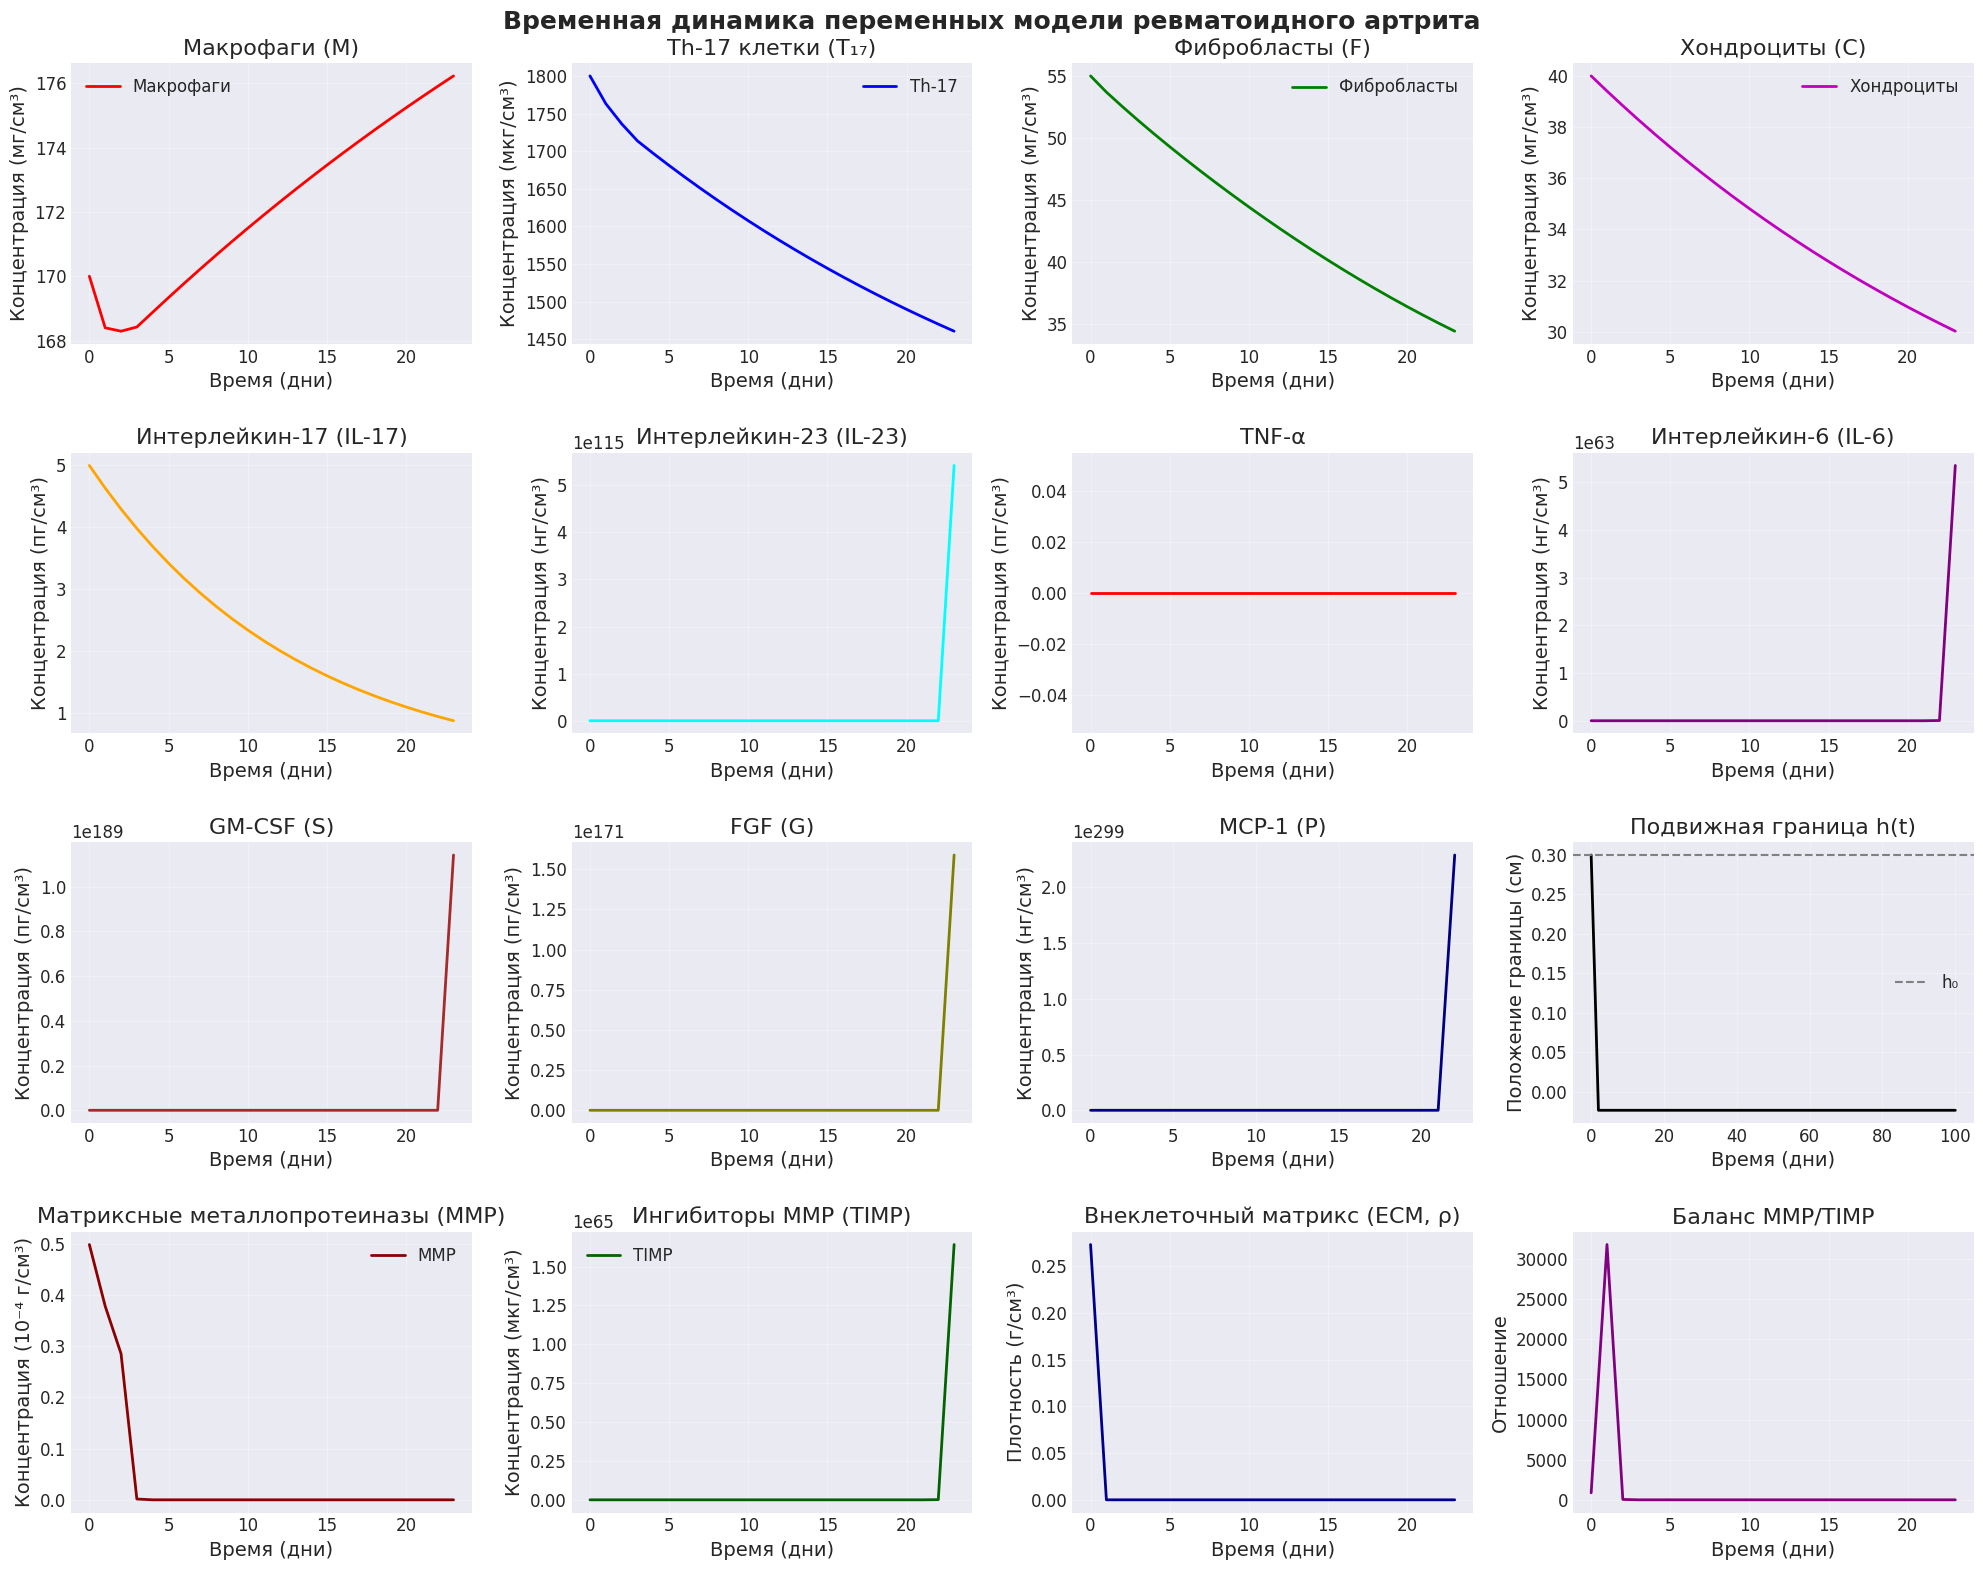


📊 Построение пространственных профилей...
   График сохранен: figures/spatial_profiles/control.png


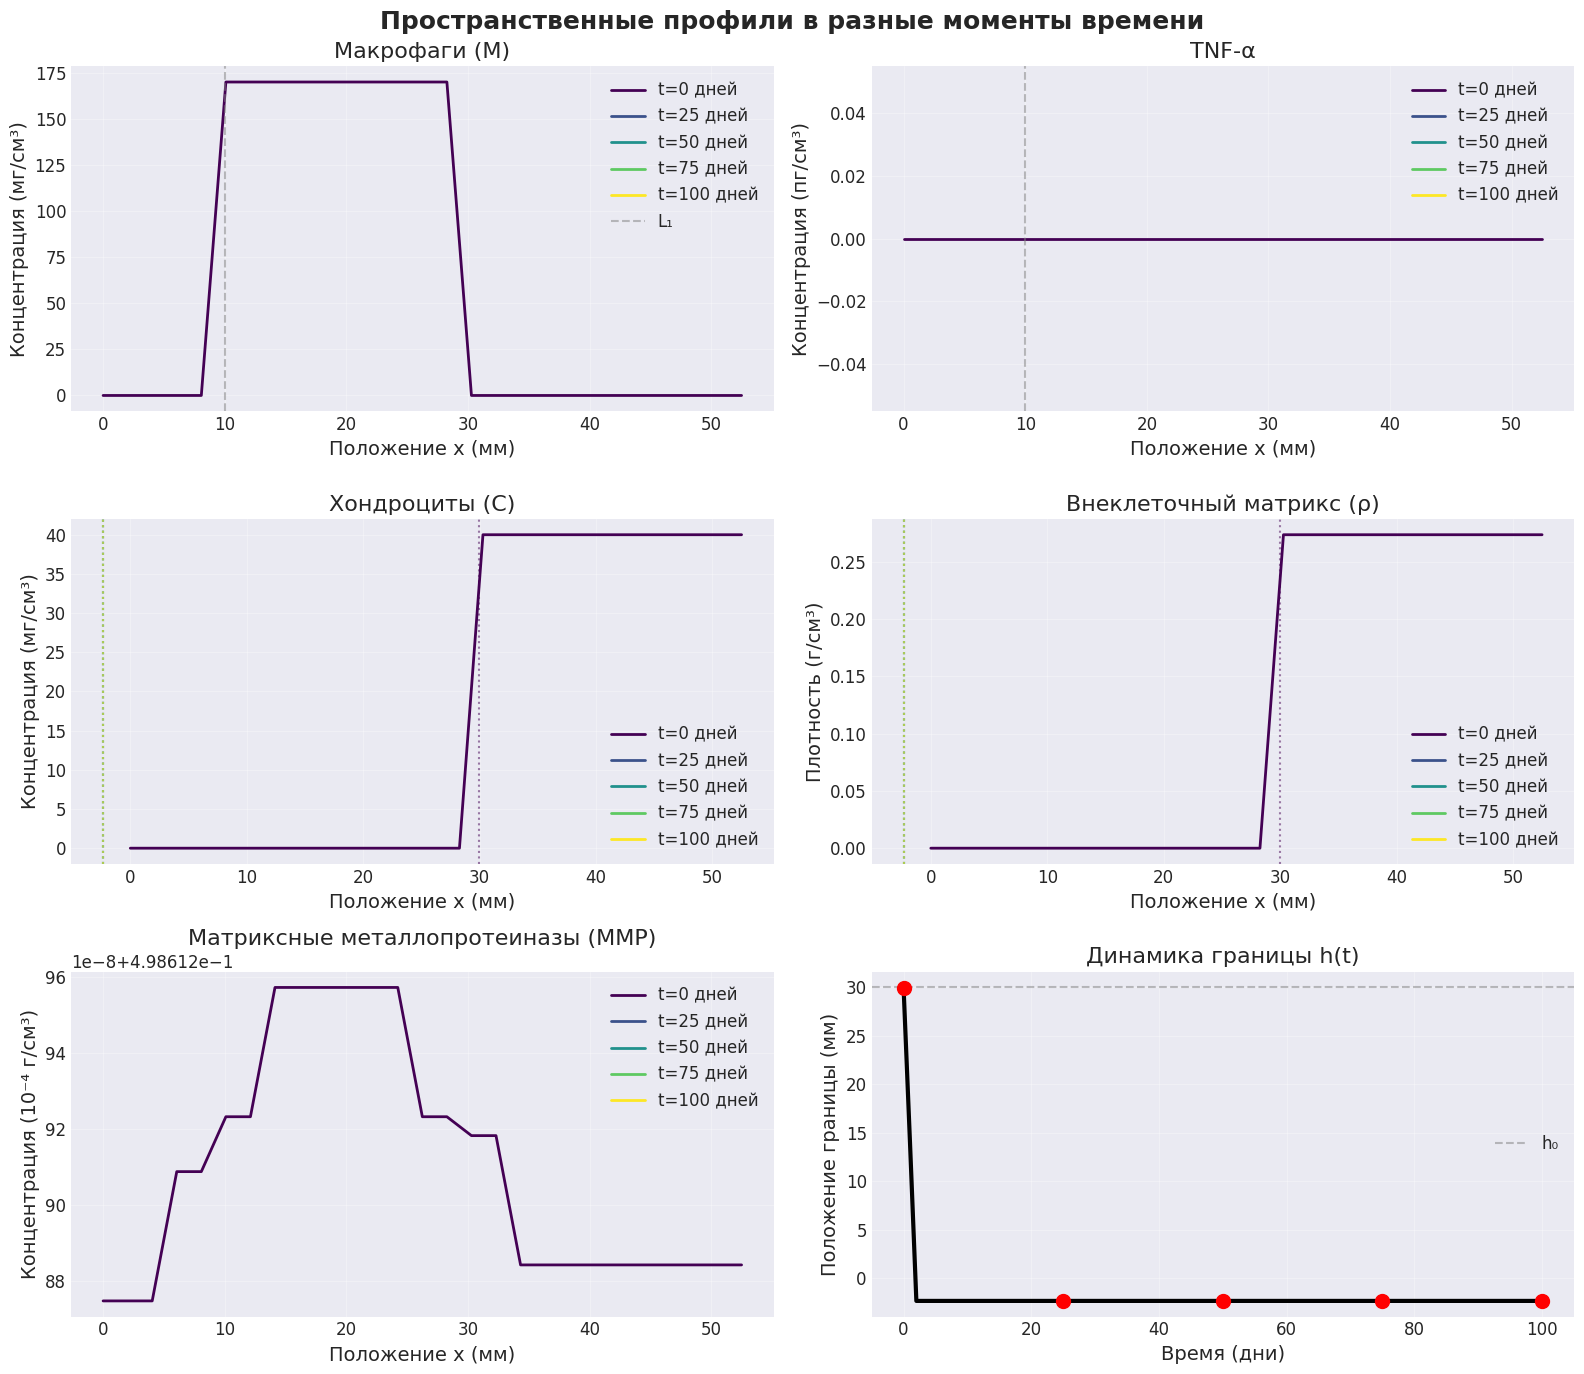

In [21]:
# Визуализация временной динамики контрольного случая
print("📊 Построение графиков временной динамики...")
plot_temporal_dynamics(results_control, 
                      save_path='figures/temporal_dynamics/control.png')

# Визуализация пространственных профилей
print("\n📊 Построение пространственных профилей...")
plot_spatial_profiles(results_control, 
                     time_points=[0, 25, 50, 75, 100],
                     save_path='figures/spatial_profiles/control.png')


### 7.5 Сравнительный анализ эффективности терапий



📊 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ ТЕРАПИЙ
📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ТЕРАПИИ
Начальное положение границы h₀:        0.3000 см (3.00 мм)
Контроль (без лечения) h(100):         -0.0234 см (-0.23 мм)
Изменение в контроле:                  -3.234 мм
----------------------------------------------------------------------
Инфликсимаб         : h(100) = -0.0234 см, эффективность = -0.00%
Метотрексат         : h(100) = -0.0234 см, эффективность = -0.00%
Тоцилизумаб         : h(100) = -0.0234 см, эффективность = -0.00%
   График сохранен: figures/treatment_comparison/comparison.png


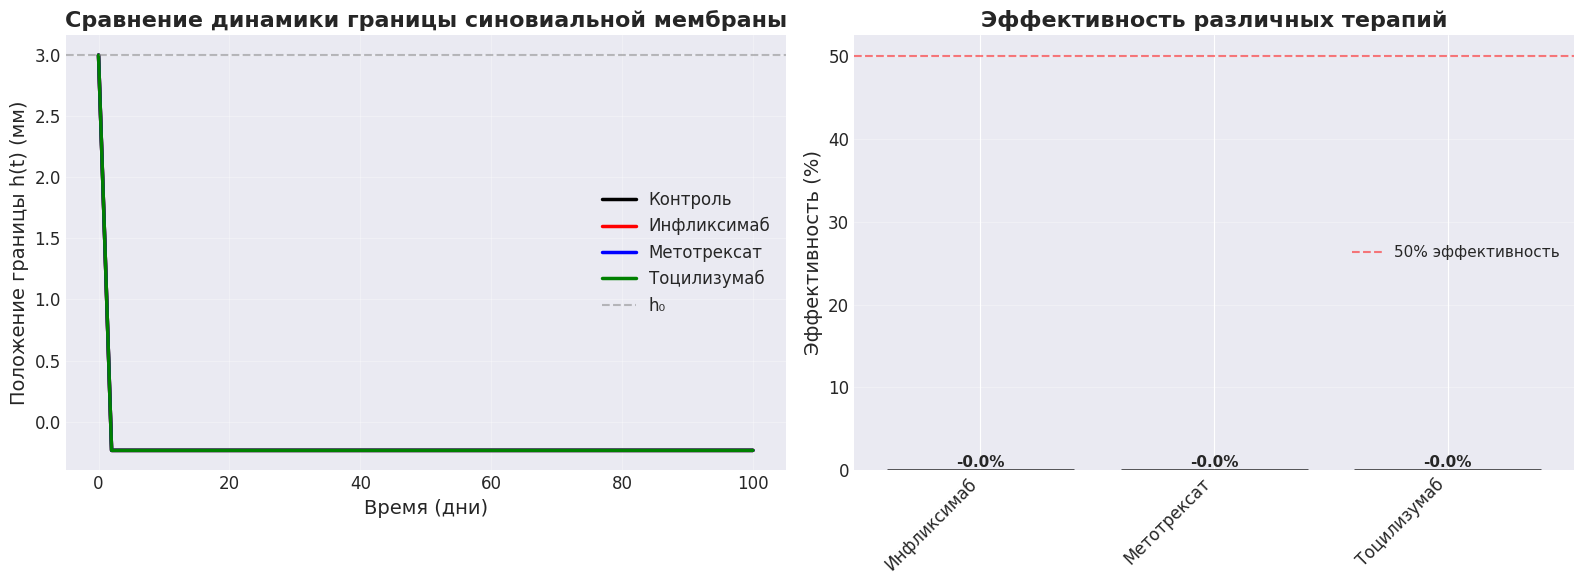


📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Терапия                   h(100), см   Δh, мм     Эффективность, %    
----------------------------------------------------------------------
Контроль                  -0.0234      -3.234     -                   
Инфликсимаб               -0.0234      -3.234     -0.00%              
Метотрексат               -0.0234      -3.234     -0.00%              
Тоцилизумаб               -0.0234      -3.234     -0.00%              


In [22]:
# Сравнительный анализ всех терапий
print("\n" + "=" * 70)
print("📊 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЭФФЕКТИВНОСТИ ТЕРАПИЙ")
print("=" * 70)

efficacy_results = compare_treatments(results_dict, 
                                     save_path='figures/treatment_comparison/comparison.png')

# Вывод сводной таблицы результатов
print("\n" + "=" * 70)
print("📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 70)
print(f"{'Терапия':<25} {'h(100), см':<12} {'Δh, мм':<10} {'Эффективность, %':<20}")
print("-" * 70)

h_initial = h0
for treatment_name, results in results_dict.items():
    h_final = results['h'][-1]
    delta_h = (h_final - h_initial) * 10  # в мм
    
    label_map = {
        'none': 'Контроль',
        'infliximab': 'Инфликсимаб',
        'methotrexate': 'Метотрексат',
        'tocilizumab': 'Тоцилизумаб'
    }
    label = label_map.get(treatment_name, treatment_name)
    
    if treatment_name == 'none':
        eff_str = '-'
    else:
        eff = efficacy_results.get(treatment_name, 0)
        eff_str = f'{eff:.2f}%'
    
    print(f"{label:<25} {h_final:<12.4f} {delta_h:<10.3f} {eff_str:<20}")

print("=" * 70)


### 7.3 Анализ эффективности терапии

Расчет эффективности каждого вида терапии по формуле (3.1) и сравнительный анализ.


In [23]:
# Функция для сравнения эффективности терапий
def compare_treatments(results_dict, save_path=None):
    """
    Сравнение эффективности различных терапий
    
    Параметры:
    -----------
    results_dict : dict
        Словарь с результатами для разных терапий
        Ключи: 'none' (контроль), 'infliximab', 'methotrexate', 'tocilizumab', и т.д.
    save_path : str
        Путь для сохранения графика
    """
    if 'none' not in results_dict:
        print("⚠️  Необходимы результаты контрольного случая для расчета эффективности")
        return
    
    h_control_final = results_dict['none']['h'][-1]
    h_initial = h0
    
    # Расчет эффективности
    efficacy_results = {}
    
    print("=" * 70)
    print("📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ТЕРАПИИ")
    print("=" * 70)
    print(f"Начальное положение границы h₀:        {h_initial:.4f} см ({h_initial*10:.2f} мм)")
    print(f"Контроль (без лечения) h(100):         {h_control_final:.4f} см ({h_control_final*10:.2f} мм)")
    print(f"Изменение в контроле:                  {(h_control_final-h_initial)*10:.3f} мм")
    print("-" * 70)
    
    for treatment_name, results in results_dict.items():
        if treatment_name == 'none':
            continue
        
        h_treatment_final = results['h'][-1]
        eff = calculate_efficacy(h_control_final, h_treatment_final, h_initial)
        efficacy_results[treatment_name] = eff
        
        print(f"{treatment_name:20s}: h(100) = {h_treatment_final:.4f} см, эффективность = {eff:.2f}%")
    
    print("=" * 70)
    
    # Построение графика сравнения
    if len(results_dict) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. Динамика границы h(t)
        ax = axes[0]
        colors_map = {
            'none': 'black',
            'infliximab': 'red',
            'methotrexate': 'blue',
            'tocilizumab': 'green',
            'combo_AY': 'purple',
            'combo_AZ': 'orange',
            'combo_YZ': 'cyan'
        }
        
        for treatment_name, results in results_dict.items():
            time = np.array(results['time'])
            color = colors_map.get(treatment_name, 'gray')
            label_map = {
                'none': 'Контроль',
                'infliximab': 'Инфликсимаб',
                'methotrexate': 'Метотрексат',
                'tocilizumab': 'Тоцилизумаб',
                'combo_AY': 'Инфликсимаб + Метотрексат',
                'combo_AZ': 'Инфликсимаб + Тоцилизумаб',
                'combo_YZ': 'Метотрексат + Тоцилизумаб'
            }
            label = label_map.get(treatment_name, treatment_name)
            ax.plot(time, results['h'] * 10, color=color, linewidth=2.5, label=label)
        
        ax.axhline(y=h0*10, color='gray', linestyle='--', alpha=0.5, label='h₀')
        ax.set_xlabel('Время (дни)', fontsize=14)
        ax.set_ylabel('Положение границы h(t) (мм)', fontsize=14)
        ax.set_title('Сравнение динамики границы синовиальной мембраны', fontsize=16, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3)
        
        # 2. Гистограмма эффективности
        ax = axes[1]
        if efficacy_results:
            treatments = list(efficacy_results.keys())
            efficacies = list(efficacy_results.values())
            colors = [colors_map.get(t, 'gray') for t in treatments]
            
            label_map_short = {
                'infliximab': 'Инфликсимаб',
                'methotrexate': 'Метотрексат',
                'tocilizumab': 'Тоцилизумаб',
                'combo_AY': 'Комбо A+Y',
                'combo_AZ': 'Комбо A+Z',
                'combo_YZ': 'Комбо Y+Z'
            }
            labels = [label_map_short.get(t, t) for t in treatments]
            
            bars = ax.bar(range(len(treatments)), efficacies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
            ax.set_xticks(range(len(treatments)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
            ax.set_ylabel('Эффективность (%)', fontsize=14)
            ax.set_title('Эффективность различных терапий', fontsize=16, fontweight='bold')
            ax.grid(True, axis='y', alpha=0.3)
            ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% эффективность')
            ax.legend(fontsize=11)
            
            # Добавляем значения на столбцы
            for i, (bar, eff) in enumerate(zip(bars, efficacies)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{eff:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"   График сохранен: {save_path}")
        
        plt.show()
    
    return efficacy_results


print("✅ Функция сравнения терапий определена")


✅ Функция сравнения терапий определена
